# Getting Started with OpenMM

## Introduction

OpenMM is a high-performance toolkit for molecular dynamics simulations.  This series of tutorials is designed to walk you through the basic steps of using OpenMM to set up and run simulations.  Once you have familiarized yourself with these basics, you can consult the [list of more advanced tutorials](../../tutorials.rst#advanced-tutorials) to learn how to accomplish more specific simulation tasks.

Before beginning, it is useful to understand a bit about the architecture of OpenMM.  The core OpenMM library is written in C++, and the [OpenMM C++ API](https://docs.openmm.org/latest/api-c++/) can be used directly to invoke OpenMM from C++ programs.  However, OpenMM provides wrappers for other languages as well, such as the [OpenMM Python API](https://docs.openmm.org/latest/api-python/).  These tutorials demonstrate how to use OpenMM from its Python API, not only due to the convenience of working with OpenMM from within Python, but also due to additional OpenMM features that are only available from Python.  In particular, the Python API consists of both:

* A lower-level ["library layer"](https://docs.openmm.org/latest/api-python/library.html) that directly wraps OpenMM's C++ interface and provides tools for building customized molecular simulation scripts, libraries, and applications from scratch, and
* A higher-level ["application layer"](https://docs.openmm.org/latest/api-python/app.html) that provides various tools for loading and applying commonly used molecular force fields, reading and writing common trajectory and topology file formats, and reporting properties during simulation runs.

In general, there are three primary methods of using OpenMM to set up and run molecular simulations:

1. Load a molecular topology, use OpenMM to modify it as needed, parameterize it with a force field, and simulate it.  This is the simplest method to perform straightforward simulations of biomolecules in OpenMM.  For example, if you have a PDB file with the structure of a particular protein, and you want to solvate it and simulate it with a standard Amber or CHARMM force field, this is the easiest method to do so.  This method uses OpenMM's application layer.
2. Use some external programs or tools (*e.g.*, LEaP from [AmberTools](https://ambermd.org/AmberTools.php), or [CHARMM-GUI](https://www.charmm-gui.org/), to do your modeling and parameterization, and load the resulting input files into OpenMM for simulation.  This method can be convenient if your desired modeling workflow is more complex than what OpenMM currently supports, or you wish to use a force field that hasn't been ported to OpenMM's native format.  It also uses OpenMM's application layer.
3. Use OpenMM's library layer to build a molecular system from scratch.  This is the most general and flexible way to use OpenMM, but requires you to explicitly define all of the necessary potential energy terms and parameters for the atoms, bonds, angles, torsions, *etc.* in your simulation, unlike the other methods that handle this setup automatically given a topology and a predefined force field.  This approach can be useful to build more complex systems when complete control over system setup is required.  However, it is also especially helpful for setting up simulations of simple model systems like Lennard-Jones fluid mixtures, bead-spring polymers, and simple coarse-grained models.

These approaches are not completely exclusive: for instance, it is possible to use OpenMM's application layer to set up a simulation, and then use the library layer to make manual modifications before running it.  However, understanding the basics of these methods is useful for understanding how to build more complex simulation workflows with OpenMM, so these introductory tutorials will walk through each of them in turn.  This first tutorial covers the first method.  In particular, we will see how to load a protein structure into OpenMM, clean up and prepare the structure for simulation, add solvent, specify a force field, and run a simulation.

The tutorials will not describe in extensive detail the use of external programs, such as Amber and CHARMM, for system setup.  When they discuss how to use OpenMM to run simulations that have been set up using other tools, links to relevant documentation for these tools will be given.  Furthermore, they will not describe in detail the basic theory behind molecular simulations, or discuss how to perform more advanced analysis of simulation results beyond extracting basic thermodynamic properties.  For links to resources on related topics not covered directly in these tutorials, refer to the [Further Reading](#Further-Reading) section of this and other tutorial notebooks.

## Installing OpenMM and Running OpenMM Setup

The most straightforward ways to install OpenMM are through either [conda-forge](https://anaconda.org/conda-forge/openmm) or [PyPI](https://pypi.org/project/OpenMM/).  If you are using `conda`, then
```shell
conda install -c conda-forge openmm
```
is all you need to get started, but more detailed instructions and a more comprehensive list of installation options can be found [in the OpenMM user manual](https://docs.openmm.org/latest/userguide/application/01_getting_started.html#installing-openmm).  (If you are following along with this notebook in Google Colab, then a cell has been inserted at the top of the notebook with commands to automatically install OpenMM into the Colab environment.)

Unlike some other molecular dynamics packages (*e.g.*, LAMMPS), an installation of OpenMM does not include a standalone executable that reads input files with parameters and commands, runs simulations, and writes results.  Instead, OpenMM simply includes a Python package `openmm` providing access to its API.  This allows you to write "input scripts" for OpenMM in Python by importing its package and using the classes and functions it provides.  In addition to having the full power and flexibility of Python available when invoking OpenMM, this approach also enables the use of OpenMM as a library inside other Python packages.

For this tutorial, where we load a protein structure and set up a straightforward molecular dynamics simulation, we will only need to write a simple script.  OpenMM provides a helpful utility, called [OpenMM Setup](https://github.com/openmm/openmm-setup), to automate writing the necessary Python scripts for simulation tasks like this.  It can be installed as an additional conda-forge package:
```shell
conda install -c conda-forge openmm-setup
```
(If you haven't already installed the `openmm` package, the `openmm-setup` package will automatically install it as a dependency.)  OpenMM Setup can be started by running the command
```shell
openmm-setup
```
in a shell, which opens its graphical user interface in a web browser.

<img src="getting_started_1.png" width="800" style="border: 1px solid black;" />

In this example, we will use a structure of hen egg white lysozyme from the Protein Data Bank with [PDB ID 1AKI](https://www.rcsb.org/structure/1AKI).  The structure can be downloaded in PDBx/mmCIF format as [1AKI.cif](https://files.rcsb.org/download/1AKI.cif) from the linked PDB entry.  If you want to follow along in OpenMM Setup, you can select the default option to load a PDB or PDBx/mmCIF file.

<img src="getting_started_2.png" width="800" style="border: 1px solid black;" />

OpenMM provides several commonly used force fields for biomolecular simulations; these are [described in the user guide](https://docs.openmm.org/latest/userguide/application/02_running_sims.html#force-fields).  Choosing an appropriate force field for your research problem is outside of the scope of this tutorial, but you should be aware of the behavior of the force field you choose and any limitations it has that might be applicable to your system.  The default force field that we will use here, which OpenMM refers to as ["Amber19"](https://docs.openmm.org/latest/userguide/application/02_running_sims.html#amber19), includes Amber ff19SB force field parameters for proteins, among others.  We will also use the default TIP3P-FB model for water; the water models distributed with the force fields built into OpenMM also contain compatible parameters for ions.

Protein structures downloaded directly from the Protein Data Bank are often not immediately suitable for running simulations.  They may be missing hydrogen atoms, and they may contain additional, *e.g.*, oxygen atoms at positions where water molecules are found in the crystal structures.  OpenMM Setup comes with a builtin interface to the [PDBFixer](https://github.com/openmm/pdbfixer) tool that can help clean up and prepare files for simulation.  Selecting the option to do this brings up a visualization window where we can inspect the structure and select actions to take:

<img src="getting_started_3.png" width="800" style="border: 1px solid black;" />

A PDB or PDBx/mmCIF file contains a hierarchical representation of a molecular structure, with atoms grouped into residues and residues grouped into chains.  Chains can correspond to single polymeric molecules consisting of a sequence of residues, but more generally, a chain may just group related residues together.  For the file we are using in this tutorial, the protein is present in chain A and all of the crystallographic water molecules are in chain B, so we can exclude the latter to remove the water molecules.  Alternatively, you can use the "delete heterogens" dropdown to remove water as well as other non-standard species from the structure.

After removing the water present in our crystal structure, we can instruct OpenMM Setup to add hydrogen atoms to the remaining protein, and add water back in the form of a solvent box surrounding it.  Here we have kept the default options except for increasing the ionic strength to 0.1 M:

<img src="getting_started_4.png" width="800" style="border: 1px solid black;" />

At last, OpenMM Setup will generate a Python script along with a PDBx/mmCIF file containing our preprocessed and solvated protein structure.  You can use OpenMM Setup to run OpenMM and monitor the simulation output directly from your web browser, but in this tutorial, we will take the script that OpenMM Setup generates and work through it line by line.  For this tutorial, we will keep the default options from OpenMM Setup, except for:

* Decreasing the value of the "Simulation Length (steps)" field in the Simulation tab to 10000 (for convenience running the simulation within a Jupyter notebook).
* Changing the "Platform" option in the Simulation tab to "CPU".  If you are running OpenMM on a computer with a GPU that supports CUDA or OpenCL, you can select the appropriate option to instruct OpenMM to use your GPU for increased performance.
* Deselecting the "Save trajectory to a file" and "Save checkpoints to a file" options in the Output tab.  The next tutorial will cover simulation output from OpenMM in more detail; in this tutorial, we will just instruct OpenMM to write some basic statistics to a text file.
* Decreasing the value of the "Data Output Interval (steps)" field in the Output tab to 100.  Since we have selected a shorter simulation length, we can save simulation properties more frequently for convenience.

If you are following along with OpenMM Setup, you should select "Save All Files" to save the generated Python script and preprocessed structure `1AKI-processed.cif`.  If you are running this tutorial as a Jupyter notebook locally in Google Colab, the necessary PDBx/mmCIF file is already provided.  The Python script generated by OpenMM Setup with the options described above set should look like:

```python
# This script was generated by OpenMM-Setup on 2025-09-19.

from openmm import *
from openmm.app import *
from openmm.unit import *

# Input Files

pdbx = PDBxFile('1AKI-processed.cif')
forcefield = ForceField('amber19-all.xml', 'amber19/tip3pfb.xml')

# System Configuration

nonbondedMethod = PME
nonbondedCutoff = 1.0*nanometers
ewaldErrorTolerance = 0.0005
constraints = HBonds
rigidWater = True
constraintTolerance = 0.000001
hydrogenMass = 1.5*amu

# Integration Options

dt = 0.004*picoseconds
temperature = 300*kelvin
friction = 1.0/picosecond
pressure = 1.0*atmospheres
barostatInterval = 25

# Simulation Options

steps = 10000
equilibrationSteps = 1000
platform = Platform.getPlatformByName('CPU')
dataReporter = StateDataReporter('log.txt', 100, totalSteps=steps,
    step=True, speed=True, progress=True, potentialEnergy=True, temperature=True, separator='\t')

# Prepare the Simulation

print('Building system...')
topology = pdbx.topology
positions = pdbx.positions
system = forcefield.createSystem(topology, nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
    constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance, hydrogenMass=hydrogenMass)
system.addForce(MonteCarloBarostat(pressure, temperature, barostatInterval))
integrator = LangevinMiddleIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(topology, system, integrator, platform)
simulation.context.setPositions(positions)

# Minimize and Equilibrate

print('Performing energy minimization...')
simulation.minimizeEnergy()
print('Equilibrating...')
simulation.context.setVelocitiesToTemperature(temperature)
simulation.step(equilibrationSteps)

# Simulate

print('Simulating...')
simulation.reporters.append(dataReporter)
simulation.currentStep = 0
simulation.step(steps)
```

## Running the Simulation

We will now examine in detail the Python script generated by OpenMM Setup.  First, we need to import OpenMM:

In [ ]:
from openmm import *

Importing the top-level module only gives access to the [library layer](https://docs.openmm.org/latest/api-python/library.html) of the Python API.  To access the [application layer](https://docs.openmm.org/latest/api-python/app.html) that we will mainly be using in this tutorial, and OpenMM's units API that we will discuss later, we can use:

In [ ]:
from openmm.app import *
from openmm.unit import *

### Input Files

Now we can load the PDBx/mmCIF file generated by OpenMM Setup using the [PDBxFile](https://docs.openmm.org/latest/api-python/generated/openmm.app.pdbxfile.PDBxFile.html) class:

In [ ]:
pdbx = PDBxFile('1AKI-processed.cif')

OpenMM supports loading [several other kinds](https://docs.openmm.org/latest/api-python/app.html#loaders-and-setup) of commonly used file formats, including, for example, files in the legacy (but ubiquitous) PDB format using [PDBFile](https://docs.openmm.org/latest/api-python/generated/openmm.app.pdbfile.PDBFile.html).

We also need to load *force field* files that contain the bonded and non-bonded interaction parameters specifying the potential energy of configurations of our system.  To load an OpenMM force field, we can create a [ForceField](https://docs.openmm.org/latest/api-python/generated/openmm.app.forcefield.ForceField.html) object with paths to XML files defining the templates and parameters for the force field:

In [ ]:
forcefield = ForceField('amber19-all.xml', 'amber19/tip3pfb.xml')

We do not need to place these files in the current working directory to load them.  OpenMM tries to look up the force field files using the paths provided first, and if they cannot be found, looks in its data directories for them.  Since we are using force fields that are distributed with OpenMM, they are loaded from the data directory that can be found at `openmm/app/data` wherever the OpenMM Python API has been installed.

The script generated by OpenMM Setup now defines several constants specifying simulation parameters.  We will discuss each of these in more detail as they are used.  OpenMM Setup allows you to adjust all of their values, although the defaults it generates should usually be appropriate for biomolecular simulations.

In [2]:
# System Configuration

nonbondedMethod = PME
nonbondedCutoff = 1.0*nanometers
ewaldErrorTolerance = 0.0005
constraints = HBonds
rigidWater = True
constraintTolerance = 0.000001
hydrogenMass = 1.5*amu

# Integration Options

dt = 0.004*picoseconds
temperature = 300*kelvin
friction = 1.0/picosecond
pressure = 1.0*atmospheres
barostatInterval = 25

# Simulation Options

steps = 10000
equilibrationSteps = 1000

NameError: name 'PME' is not defined

In [ ]:
platform = Platform.getPlatformByName('CPU')

In [ ]:
dataReporter = StateDataReporter('log.txt', 100, totalSteps=steps,
    step=True, speed=True, progress=True, potentialEnergy=True, temperature=True, separator='\t')

In [ ]:
topology = pdbx.topology
positions = pdbx.positions

In [ ]:
system = forcefield.createSystem(topology, nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
    constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance, hydrogenMass=hydrogenMass)

In [ ]:
system.addForce(MonteCarloBarostat(pressure, temperature, barostatInterval))

In [ ]:
integrator = LangevinMiddleIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)

In [ ]:
simulation = Simulation(topology, system, integrator, platform)

In [ ]:
simulation.context.setPositions(positions)

In [ ]:
simulation.minimizeEnergy()

In [ ]:
simulation.context.setVelocitiesToTemperature(temperature)

In [ ]:
simulation.step(equilibrationSteps)

In [ ]:
simulation.reporters.append(dataReporter)

In [ ]:
simulation.currentStep = 0
simulation.step(steps)

In [3]:
from openmm import *

In [4]:
from openmm.app import *
from openmm.unit import *

In [5]:
pdbx = PDBxFile('1AKI-processed.cif')

In [6]:
forcefield = ForceField('amber19-all.xml', 'amber19/tip3pfb.xml')

In [5]:
pdbx.topology

<Topology; 2 chains, 207 residues, 1079 atoms, 1025 bonds>

The object produced by loading the file has a `positions` attribute, with the actual coordinates contained in the file, as well as a `topology` attribute:

OpenMM [Topology](https://docs.openmm.org/latest/api-python/generated/openmm.app.topology.Topology.html) objects contain information about the identity and connectivity of the particles in a molecular system.  Topology objects arrange their data hierarchically, with each Topology containing a list of chains, each chain a list of residues, and each residue a list of atoms.  For biopolymers such as proteins, OpenMM's concepts of chains and residues generally map onto their standard meanings in this context.  More generally, a residue in a Topology represents a set of atoms that is used by OpenMM to assign simulation parameters from a force field (this is discussed in more detail later).  Chains in a Topology provide a convenient way to collect related residues; they are useful to group residues that make up subsets of atoms in a larger molecule.

In order to go further, we need to specify a *force field* that defines bonded and non-bonded interaction parameters that specify the potential energy of configurations of our system.  In the OpenMM application layer, force fields work by matching *residue templates* in the force field to residues in a Topology.  A residue must have the correct number of atoms of each element, and the correct bonds between them as well as to other residues, to match a residue template in a force field.  OpenMM provides several commonly used force fields for biomolecular simulations; these are [described in the user guide](https://docs.openmm.org/latest/userguide/application/02_running_sims.html#force-fields).  Choosing an appropriate force field for your research problem is outside of the scope of this tutorial, but you should be aware of the behavior of the force field you choose and any limitations it has that might be applicable to your system.

Here we will use what OpenMM refers to as the ["Amber19"](https://docs.openmm.org/latest/userguide/application/02_running_sims.html#amber19) force field, which includes the Amber ff19SB force field for proteins, among others.  To load a force field, create a [ForceField](https://docs.openmm.org/latest/api-python/generated/openmm.app.forcefield.ForceField.html) object with paths to XML files defining the templates and parameters for the force field:

In [11]:
ff = openmm.app.ForceField("amber19-all.xml", "amber19/opc3.xml")

  Note that in addition to Amber19, we have loaded parameters for the OPC3 water model (and ions) that are compatible with it.

With a ForceField, Modeller can now add hydrogens to its Topology:

You may notice that we have passed quantities with units as arguments to Modeller.addSolvent().  OpenMM's Python API supports automatic unit conversions and dimension checking through the [openmm.unit](https://docs.openmm.org/latest/api-python/app.html#units) package.  If raw values without units are provided to OpenMM, it will assume that they are appropriately dimensioned quantities in OpenMM's [default unit system](https://docs.openmm.org/latest/userguide/theory/01_introduction.html#units).  However, always using the units API can help prevent unit conversion mistakes.  More information can be found [in the user guide](https://docs.openmm.org/latest/userguide/library/05_languages_not_cpp.html#units-and-dimensional-analysis).

Finally, we have a topology that is ready for simulation, with all of the added atoms that we need, and periodic box vectors set:

In [14]:
modeller.topology

<Topology; 3 chains, 7044 residues, 22641 atoms, 15750 bonds>

In [15]:
modeller.topology.getPeriodicBoxVectors()

(Vec3(x=6.199413656965853, y=0, z=0), Vec3(x=0, y=6.199413656965853, z=0), Vec3(x=0, y=0, z=6.199413656965853)) nm

Besides hydrogen atoms, Modeller can be used to add extra particles for force fields that require them, *e.g.*, virtual sites for 4- and 5-site water models, and Drude sites for polarizable force fields.  Modeller can also add lipid bilayers, which is useful for simulations of proteins embedded in membranes.  For more complex structure preparation and setup tasks, you may need to employ external tools.  For PDB structures that require more work than simply adding hydrogen atoms, [PDBFixer](https://github.com/openmm/pdbfixer) may be helpful.  It can add heavy atoms and even loops of residues missing from protein structures, remove unwanted molecules, and more.

## Running a Simulation

Once we have Topology and ForceField objects, we can create an OpenMM [System](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.System.html) using the [ForceField.createSystem()](https://docs.openmm.org/latest/api-python/generated/openmm.app.forcefield.ForceField.html#openmm.app.forcefield.ForceField.createSystem) method.  The documentation describes the many options that this method can take, but here we show just the most important ones:

In [16]:
system = ff.createSystem(modeller.topology,
                         nonbondedMethod=openmm.app.PME,
                         nonbondedCutoff=1.0 * openmm.unit.nanometer,
                         constraints=openmm.app.HBonds)

The `nonbondedMethod` argument controls how nonbonded interactions between atoms will be computed.  PME is the particle mesh Ewald method, which is usually preferable when the system you are simulating has charges and uses periodic boundary conditions.  The `nonbondedCutoff` distance specifies a cutoff for Lennard-Jones interactions, and controls the splitting between Coulomb interactions computed in direct *vs.* reciprocal space.  More information about the theory used by OpenMM to compute these interactions can be found in the [user guide](https://docs.openmm.org/latest/userguide/theory/02_standard_forces.html#nonbondedforce).  The value of 1 nm selected here is also the default.  The `constraints` argument controls which interparticle distances in a simulation OpenMM will apply rigid constraints to.  The HBonds option selects all bonds to hydrogen atoms, which typically have large force constants and thus generate high-frequency motion.  Constraining them to fixed distances allows the simulation to use a larger timestep while still remaining stable.

The System object created contains all of the atoms in the topology, as well as OpenMM [Force](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.Force.html) objects defining the interactions between them.  These Force objects are created by the ForceField when it matches residue templates to residues in the Topology and assigns parameters.

In [17]:
system.getNumParticles()

22641

In [18]:
system.getForces()

[<openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x11a7bf3c0> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x10f495500> >,
 <openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x10f495650> >,
 <openmm.openmm.CMAPTorsionForce; proxy of <Swig Object of type 'OpenMM::CMAPTorsionForce *' at 0x10f495710> >,
 <openmm.openmm.CMMotionRemover; proxy of <Swig Object of type 'OpenMM::CMMotionRemover *' at 0x10f495560> >,
 <openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x10f490990> >]

Here, we can treat the System object largely as a black box that describes to OpenMM how to calculate the energy and forces for a given set of positions of the atoms in our structure.  In a later tutorial, we will see how to build a System and set up Force objects from scratch, without using a predefined ForceField.

To perform molecular dynamics simulations, we need to select an integration algorithm.  In OpenMM, we do so by creating an [Integrator](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.Integrator.html) object.  Subclasses of Integrator define specific integration algorithms.  Here, we will use the [LangevinMiddleIntegrator](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.LangevinMiddleIntegrator.html), which uses Langevin dynamics to simulate a System and maintain its temperature at a fixed setpoint:

In [19]:
integrator = openmm.LangevinMiddleIntegrator(300.0 * openmm.unit.kelvin, 1.0 / openmm.unit.picosecond, 0.004 * openmm.unit.picosecond)

The first parameter sets the temperature, the second sets the friction coefficient (in inverse time units), and the third sets the integration timestep.  Choosing appropriate thermostat parameters is beyond the scope of this tutorial, but the timestep chosen here should work with the constraint option we selected earlier.

As is, the integrator will act as a thermostat, causing the total energy of the system to fluctuate in order to maintain the set temperature.  However, the system volume will remain fixed.  To perform a simulation at constant pressure instead, we will need to add a barostat:

In [20]:
system.addForce(openmm.MonteCarloBarostat(1.0 * openmm.unit.atmosphere, integrator.getTemperature()));

OpenMM provides [MonteCarloBarostat](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.MonteCarloBarostat.html) as a barostat that uniformly scales the size of the periodic box vectors.  Other, anisotropic barostats are also available.  Note that in addition to the desired pressure, we must pass the temperature set in the chosen thermostat to the barostat.  Though the barostat does not also regulate the temperature of the system, this temperature must be specified so that the barostat can calculate the correct probability that a volume adjustment Monte Carlo move should be accepted.

We are now ready to put all of the pieces together and create an OpenMM [Simulation](https://docs.openmm.org/latest/api-python/generated/openmm.app.simulation.Simulation.html) object:

In [21]:
simulation = openmm.app.Simulation(modeller.topology, system, integrator)

We can access the Topology, System, and Integrator for the Simulation as its `topology`, `system`, and `integrator` attributes.  However, the Simulation has also created an OpenMM [Context](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.Context.html).

In [22]:
simulation.context

<openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x11f767360> >

Unlike a System, that just defines information about particles and the interactions between them, a Context stores all of the information about the state of a simulation, including particle positions and velocities.  A System object acts somewhat like a template for creating Context objects, and one System could be used to create more than one Context if desired.  The interaction parameters, and other properties, stored in a Context are dependent on the parameters set in the System when the Context was created.  If changes are made to a System after a Context has been created from it, the Context will not automatically reflect these changes (although in certain cases, it is possible to update a Context with new parameters from a System).

You may have noticed that we only used the `topology` from our Modeller, and not its `positions`, when creating the System.  Now that we have a Context, we can initialize it with the positions from the Modeller.

In [23]:
simulation.context.setPositions(modeller.positions)

Although there should not be severe problems like overlapping particles in our initial positions, it is a good idea to run a local energy minimization before starting a simulation.  The distances between protein atoms from the PDB structure might differ from their equilibrium values defined by the force field, and the solvent molecules added by the Modeller might not have optimal orientations.  Minimizing the energy can prevent large initial forces that could otherwise destabilize a simulation.  OpenMM makes this easy to do:

In [24]:
simulation.minimizeEnergy()

OpenMM provides various options for reporting simulation results, which we will explore in more detail in the next tutorial.  For now, we can simply use OpenMM's [StateDataReporter](https://docs.openmm.org/latest/api-python/generated/openmm.app.statedatareporter.StateDataReporter.html) to print some basic information about our simulation to a file.

In [25]:
simulation.reporters.append(openmm.app.StateDataReporter("simulation.log",
                                                         reportInterval=100,
                                                         time=True,
                                                         potentialEnergy=True,
                                                         temperature=True,
                                                         density=True))

At last, we can run some simulation steps:

In [26]:
simulation.step(25000)

The format of the data file written by the StateDataReporter is very simple:

In [27]:
!head simulation.log

#"Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Density (g/mL)"
0.4000000000000003,-414456.1200252739,101.29547329495789,0.9750766997706524
0.8000000000000006,-402315.4096746808,169.88594724723103,0.9842334648972402
1.2000000000000008,-393341.3418421857,211.74217284525682,0.9893346735050422
1.6000000000000012,-387354.3225855497,240.16775930792363,0.9909134900476821
2.0000000000000013,-382707.2542261747,255.91778495680424,0.9909134900476821
2.4000000000000017,-379220.9490103484,271.59592640283296,0.99424587932129
2.800000000000002,-376977.17452490446,280.29570038675007,0.9999559383003619
3.2000000000000024,-375428.06519079674,286.519293863457,1.0013580310820545
3.6000000000000028,-374121.08276892174,289.3392525058974,1.0013580310820545


We can plot the results to qualitatively assess how quickly these parameters approach equilibrium values:

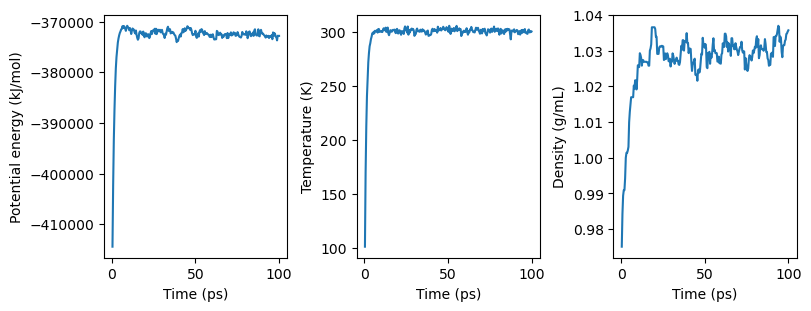

In [28]:
time, pe, temp, rho = numpy.loadtxt("simulation.log", delimiter=",").T

figure = matplotlib.pyplot.figure(figsize=(8, 3), layout="constrained")

axes_pe = figure.add_subplot(1, 3, 1)
axes_pe.plot(time, pe)
axes_pe.set_xlabel("Time (ps)")
axes_pe.set_ylabel("Potential energy (kJ/mol)")

axes_temp = figure.add_subplot(1, 3, 2)
axes_temp.plot(time, temp)
axes_temp.set_xlabel("Time (ps)")
axes_temp.set_ylabel("Temperature (K)")

axes_rho = figure.add_subplot(1, 3, 3)
axes_rho.plot(time, rho)
axes_rho.set_xlabel("Time (ps)")
axes_rho.set_ylabel("Density (g/mL)")

matplotlib.pyplot.show()

We can see that there is a relatively quick jump in the potential energy, temperature, and density as the system equilibrates.  Of course, in a production simulation, a longer simulation time would be used, along with more advanced analysis to understand whether or not the structure of the protein is changing over time.  The simulation is intentionally kept short for this tutorial, and more complex analysis is out of its scope.

Since the several steps taken in this tutorial are interspersed with additional commands to illustrate their results, the key commands that are actually important for running OpenMM are given in a self-contained script below:

```python
import openmm
import openmm.app
import openmm.unit

# Load the input structure.
pdbx = openmm.app.PDBxFile("1AKI.cif")

# Delete existing waters, add hydrogens, and add solvent.
modeller = openmm.app.Modeller(pdbx.topology, pdbx.positions)
modeller.deleteWater()
ff = openmm.app.ForceField("amber19-all.xml", "amber19/opc3.xml")
modeller.addHydrogens(ff)
modeller.addSolvent(ff, padding=1.0 * openmm.unit.nanometer, ionicStrength=0.1 * openmm.unit.molar)

# Create a System, thermostatting Integrator, and barostat.
system = ff.createSystem(modeller.topology,
                         nonbondedMethod=openmm.app.PME,
                         nonbondedCutoff=1.0 * openmm.unit.nanometer,
                         constraints=openmm.app.HBonds)
integrator = openmm.LangevinMiddleIntegrator(300.0 * openmm.unit.kelvin, 1.0 / openmm.unit.picosecond, 0.004 * openmm.unit.picosecond)
system.addForce(openmm.MonteCarloBarostat(1.0 * openmm.unit.atmosphere, integrator.getTemperature()))

# Create a Simulation.
simulation = openmm.app.Simulation(modeller.topology, system, integrator)

# Minimize the energy of the initial configuration.
simulation.context.setPositions(modeller.positions)
simulation.minimizeEnergy()

# Set up logging and run the simulation.
simulation.reporters.append(openmm.app.StateDataReporter("simulation.log",
                                                         reportInterval=100,
                                                         time=True,
                                                         potentialEnergy=True,
                                                         temperature=True,
                                                         density=True))
simulation.step(25000)
```

## Summary

After following this tutorial, you should now be able to use OpenMM to:

* Load a PDBx/mmCIF file and perform basic modeling tasks like adding hydrogen atoms and a solvent box.
* Set up a simulation at constant temperature and pressure and run an energy minimization.
* Run molecular dynamics steps and set up OpenMM to write basic thermodynamic properties to an output file.

In the next tutorial, we will discuss various ways of getting data in and out of OpenMM.  We will cover how to read input files in formats designed for other molecular dynamics engines like Amber, and how to get various kinds of data, including simulation trajectories, out of OpenMM while running a simulation.

## Further Reading

* Relevant sections of the [User Guide](https://docs.openmm.org/latest/api-python/):
  * [Chapter 3: Running Simulations](https://docs.openmm.org/latest/userguide/application/02_running_sims.html)
  * [Chapter 4: Model Building and Editing](https://docs.openmm.org/latest/userguide/application/03_model_building_editing.html)
  * [Section 12.3: Python API](https://docs.openmm.org/latest/userguide/library/05_languages_not_cpp.html#python-api)
* [Python API documentation](https://docs.openmm.org/latest/api-python/) pages for classes used in this tutorial:
  * [ForceField](https://docs.openmm.org/latest/api-python/generated/openmm.app.forcefield.ForceField.html)
  * [LangevinMiddleIntegrator](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.LangevinMiddleIntegrator.html)
  * [Modeller](https://docs.openmm.org/latest/api-python/generated/openmm.app.modeller.Modeller.html)
  * [MonteCarloBarostat](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.MonteCarloBarostat.html)
  * [PDBxFile](https://docs.openmm.org/latest/api-python/generated/openmm.app.pdbxfile.PDBxFile.html)
  * [Simulation](https://docs.openmm.org/latest/api-python/generated/openmm.app.simulation.Simulation.html)
  * [StateDataReporter](https://docs.openmm.org/latest/api-python/generated/openmm.app.statedatareporter.StateDataReporter.html)
* Troubleshooting basics:
  * If you cannot even `import openmm` from Python, make sure that you have followed the [installation instructions](https://docs.openmm.org/latest/userguide/application/01_getting_started.html#installing-openmm) carefully.
  * If you can import OpenMM in Python, but are encountering problems running simulations, the OpenMM [Frequently Asked Questions](https://github.com/openmm/openmm/wiki/Frequently-Asked-Questions) discusses some common errors and how to resolve them.
  * If the documentation does not address the problem you are having, feel free to ask for help on the OpenMM [discussion board](https://github.com/openmm/openmm/discussions).